In [1]:
from datetime import datetime
import math
import os
import sqlite3
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
data_directory = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/data/nrel'
figure_directory = '../figures'
database_filepath = os.path.join(data_directory,'resstock.sql')
con = sqlite3.connect(database_filepath)

In [45]:
timeseries_output = pd.read_sql("SELECT * FROM data_dictionary WHERE field_location = 'timeseries'",con)[['field_name']].copy()
timeseries_output.to_csv('../data/timeseries_output.txt',index=False)
building_ids = pd.read_sql("""SELECT DISTINCT bldg_id FROM building_timeseries""",con)['bldg_id'].tolist()
building_ids
building_timeseries_normalize_query = lambda building_id, variable: f"""
WITH hourly_timeseries AS (
    SELECT
        bldg_id AS building_id,
        DATE(timestamp) AS date,
        CAST(strftime('%H', timestamp) AS INTEGER) AS hour,
        SUM({variable}) as value
    FROM building_timeseries
    WHERE bldg_id = {building_id}
    GROUP BY
        bldg_id,
        DATE(timestamp),
        CAST(strftime('%H', timestamp) AS INTEGER)
)

SELECT
    t.building_id,
    t.date,
    t.hour,
    (t.value - b.minimum) / (b.maximum - b.minimum) AS normalized_value
FROM hourly_timeseries t
LEFT JOIN (
    SELECT
        building_id,
        MIN(value) AS minimum,
        MAX(value) AS maximum
    FROM hourly_timeseries
) b ON b.building_id = t.building_id
"""

In [5]:
# KMeans clustering of profiles
# Find out the distribution of ideal k for each building_id
n_clusters = list(range(2,10))
sse_record_list = []
label_data_list = []
n_cluster_data_list = []
variables = [
    'out_electricity_plug_loads_energy_consumption',
    'out_electricity_cooling_energy_consumption',
    'out_electricity_heating_energy_consumption',
    'out_electricity_vehicle_energy_consumption',
    'out_electricity_water_systems_energy_consumption',
    'out_fuel_oil_heating_energy_consumption',
    'out_natural_gas_heating_energy_consumption',
    'out_propane_heating_energy_consumption',
    'out_wood_heating_energy_consumption',
]
# building_ids = building_ids[0:5]

for i, variable in enumerate(variables):
    for j, building_id in enumerate(building_ids):
        query = building_timeseries_normalize_query(building_id,variable)
        data = pd.read_sql(query,con)
        data = data.pivot(index='date',columns='hour',values='normalized_value')
        data = data.dropna()
        x = data[data.columns.tolist()].copy()

        if len(x) != 0:
            for n_cluster in n_clusters:
                model = KMeans(n_clusters=n_cluster,random_state=0).fit(x)
                sse_record_list.append({'building_id':building_id,'variable':variable,'n_cluster':n_cluster,'sse':model.inertia_})
                n_cluster_data = data.copy()
                n_cluster_data['label'] = model.labels_
                label_data = n_cluster_data[['label']].reset_index(drop=False).copy()
                label_data['building_id'] = building_id
                label_data['variable'] = variable
                label_data['n_cluster'] = n_cluster
                label_data_list.append(label_data)
                n_cluster_data = n_cluster_data.groupby('label').describe().reset_index(drop=False)
                n_cluster_data['building_id'] = building_id
                n_cluster_data['variable'] = variable
                n_cluster_data['n_cluster'] = n_cluster
                n_cluster_data_list.append(n_cluster_data)
        else:
            pass
        

        print(
            f'\rCompleted {i}/{len(variables)} variables,'\
            f' {(i*len(building_ids) + (j + 1))}/{len(variables)*len(building_ids)} timeseries'\
            f' ({round((i*len(building_ids) + (j + 1))/(len(variables)*len(building_ids)),2)}%)',
            end=""
        )

print()
sse_data = pd.DataFrame(sse_record_list)
plot_data = sse_data.groupby(['variable','n_cluster'])[['sse']].describe().reset_index()
ax_size = (4,3)
column_count_limit = 4
row_count = math.ceil(len(plot_data['variable'].unique())/column_count_limit)
column_count = min([column_count_limit,len(plot_data['variable'].unique())])
fig, axs = plt.subplots(
    row_count,
    column_count,
    figsize=(ax_size[0]*column_count,ax_size[1]*row_count),
)

for ax, (variable, group) in zip(fig.axes, plot_data.groupby('variable')):
    ax.margins(0)
    x = group['n_cluster']
    ax.plot(x,group[('sse','mean')],color='red',label='Mean')
    ax.plot(x,group[('sse','50%')],color='green',label='Median')
    ax.fill_between(x,group[('sse','25%')],group[('sse','75%')],color='grey',alpha=0.7,label='IQR')
    ax.set_xlabel('n_cluster')
    ax.set_ylabel('SSE')
    ax.set_title(f'{variable}',fontsize=10)
    ax.legend()

plt.tight_layout()
plt.show()

Completed 4/9 variables, 4144/9180 timeseries (0.45%)

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.


Completed 4/9 variables, 4212/9180 timeseries (0.46%)

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate point

Completed 4/9 variables, 4287/9180 timeseries (0.47%)

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.


Completed 4/9 variables, 4420/9180 timeseries (0.48%)

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (6). Possibly due to duplicate points in X.


Completed 4/9 variables, 4503/9180 timeseries (0.49%)

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (6). Possibly due to duplicate points in X.


Completed 4/9 variables, 4562/9180 timeseries (0.5%)

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.


Completed 4/9 variables, 4798/9180 timeseries (0.52%)

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (7). Possibly due to duplicate points in X.
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (8). Possibly due to duplicate points in X.
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (6) found smaller than n_clusters (9). Possibly due to duplicate points in X.


Completed 4/9 variables, 4926/9180 timeseries (0.54%)

/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/citylearn/env/lib/python3.7/site-packages/ipykernel_launcher.py:30: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (9). Possibly due to duplicate points in X.


Completed 6/9 variables, 6558/9180 timeseries (0.71%)

KeyboardInterrupt: 

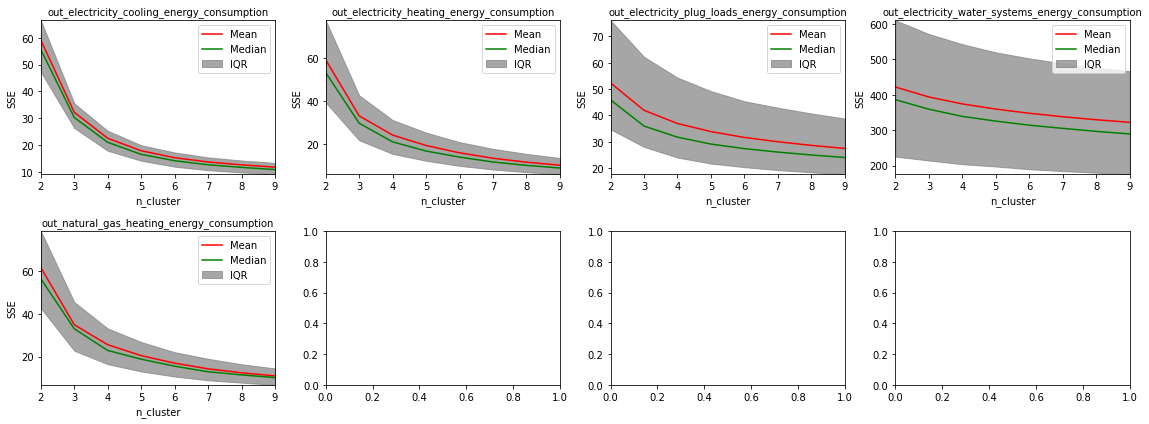

In [9]:
sse_data = pd.DataFrame(sse_record_list)
plot_data = sse_data.groupby(['variable','n_cluster'])[['sse']].describe().reset_index()
ax_size = (4,3)
column_count_limit = 4
row_count = math.ceil(len(plot_data['variable'].unique())/column_count_limit)
column_count = min([column_count_limit,len(plot_data['variable'].unique())])
fig, axs = plt.subplots(
    row_count,
    column_count,
    figsize=(ax_size[0]*column_count,ax_size[1]*row_count),
)

for ax, (variable, group) in zip(fig.axes, plot_data.groupby('variable')):
    ax.margins(0)
    x = group['n_cluster']
    ax.plot(x,group[('sse','mean')],color='red',label='Mean')
    ax.plot(x,group[('sse','50%')],color='green',label='Median')
    ax.fill_between(x,group[('sse','25%')],group[('sse','75%')],color='grey',alpha=0.7,label='IQR')
    ax.set_xlabel('n_cluster')
    ax.set_ylabel('SSE')
    ax.set_title(f'{variable}',fontsize=10)
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
# save
n_cluster_data = pd.concat(n_cluster_data_list,ignore_index=True)
n_cluster_data.to_pickle(os.path.join(data_directory,'n_cluster.pkl'))
label_data = pd.concat(label_data_list,ignore_index=True)
label_data.to_pickle(os.path.join(data_directory,'label.pkl'))
sse_data.to_pickle(os.path.join(data_directory,'sse.pkl'))

# n_cluster_data = pd.read_pickle(os.path.join(data_directory,'n_cluster.pkl'))
# label_data = pd.read_pickle(os.path.join(data_directory,'label.pkl'))
# sse_data = pd.read_pickle(os.path.join(data_directory,'sse.pkl'))

In [10]:
n_cluster = [
    {'variable':'out_electricity_plug_loads_energy_consumption','n_cluster':3},
    {'variable':'out_electricity_cooling_energy_consumption','n_cluster':4},
    {'variable':'out_electricity_heating_energy_consumption','n_cluster':4},
    {'variable':'out_electricity_vehicle_energy_consumption','n_cluster':3},
    {'variable':'out_electricity_water_systems_energy_consumption','n_cluster':4},
    {'variable':'out_fuel_oil_heating_energy_consumption','n_cluster':3},
    {'variable':'out_natural_gas_heating_energy_consumption','n_cluster':4},
    {'variable':'out_propane_heating_energy_consumption','n_cluster':3},
    {'variable':'out_wood_heating_energy_consumption','n_cluster':3},
]
n_cluster = pd.DataFrame(n_cluster)
n_cluster_data = pd.concat(n_cluster_data_list,ignore_index=True)
n_cluster_data = n_cluster_data.melt(
    id_vars=[('label',''),('building_id',''),('variable',''),('n_cluster','')],
)
n_cluster_data.columns = ['label','building_id','variable','n_cluster','hour','statistic','value']
n_cluster_data = pd.merge(n_cluster_data,n_cluster,on=['variable','n_cluster'],how='inner')

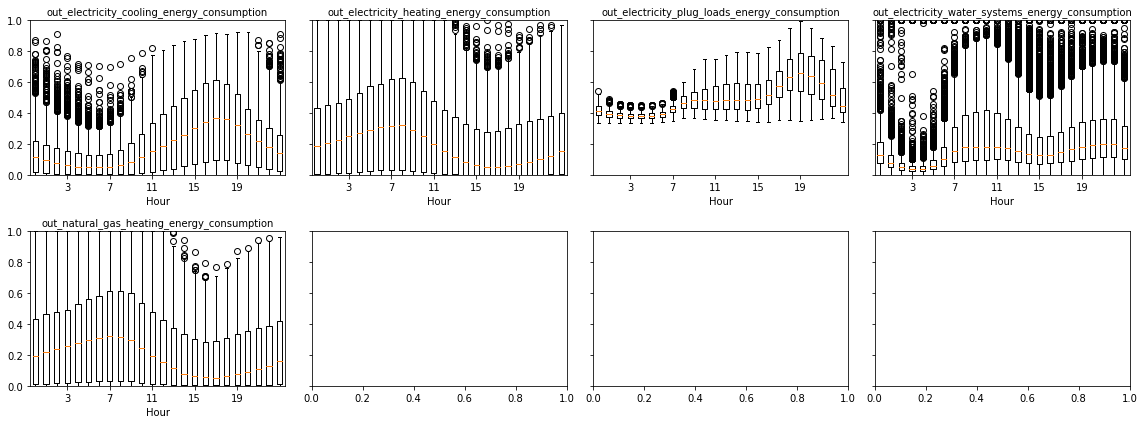

In [11]:
# distribution of load profile centroids
plot_data = n_cluster_data[n_cluster_data['statistic']=='mean'].copy()
ax_size = (4,3)
column_count_limit = 4
row_count = math.ceil(len(plot_data['variable'].unique())/column_count_limit)
column_count = min([column_count_limit,len(plot_data['variable'].unique())])
fig, axs = plt.subplots(row_count,column_count,figsize=(ax_size[0]*column_count,ax_size[1]*row_count),sharey=True)

for ax, (variable, group) in zip(fig.axes, plot_data.groupby('variable')):
    group = group.pivot_table(index=['building_id','label'],columns='hour',values='value')
    ax.boxplot(group.values)
    xticks = [i for i in range(0,24,4)]
    ax.set_xticks(xticks)
    ax.set_xticklabels([i-1 for i in xticks])
    ax.set_xlabel('Hour')
    ax.set_ylabel(None)
    ax.set_title(variable,fontsize=10)
    ax.margins(0,0)

plt.tight_layout()
plt.show()

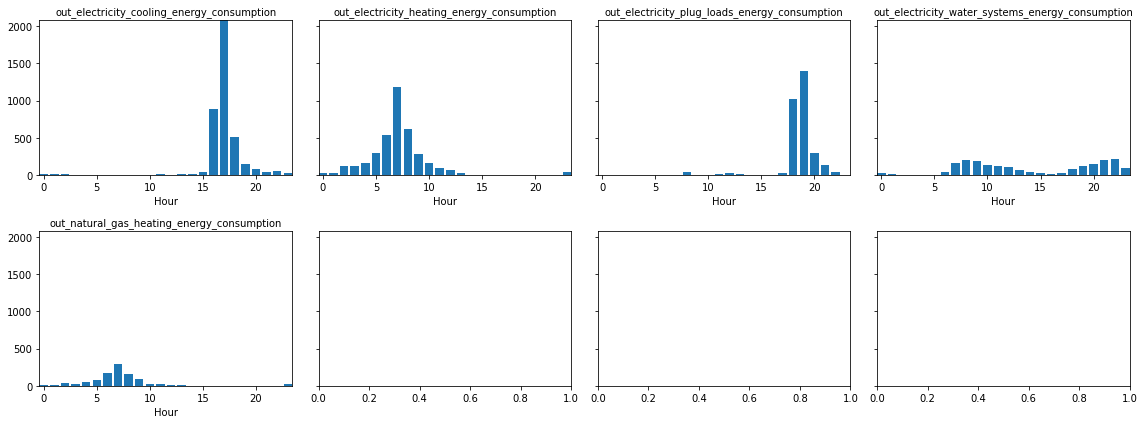

In [12]:
# distribution of peak load time
plot_data = n_cluster_data[n_cluster_data['statistic']=='mean'].copy()
hours = plot_data[['hour']].drop_duplicates().sort_values('hour').reset_index(drop=True)
hours['ix'] = hours.index
plot_data = plot_data.loc[plot_data.groupby(['building_id','variable','label'])['value'].idxmax()].copy()
plot_data = plot_data.groupby(['variable','hour']).size().reset_index(name='count').sort_values('hour')
ax_size = (4,3)
column_count_limit = 4
row_count = math.ceil(len(plot_data['variable'].unique())/column_count_limit)
column_count = min([column_count_limit,len(plot_data['variable'].unique())])
fig, axs = plt.subplots(row_count,column_count,figsize=(ax_size[0]*column_count,ax_size[1]*row_count),sharey=True)

for ax, (variable, group) in zip(fig.axes, plot_data.groupby('variable')):
    group = pd.merge(group,hours,on='hour',how='right').sort_values('ix')
    group['count'] = group['count'].fillna(0)
    ax.bar(group['ix'],group['count'])
    ax.set_title(variable,fontsize=10)
    ax.set_xlabel('Hour')
    ax.set_ylabel(None)
    ax.margins(0)
    
plt.tight_layout()
plt.show()

In [13]:
# centroid
plot_data = n_cluster_data[n_cluster_data['statistic']=='mean'].copy()
ax_size = (4,2.5)
column_count_limit = 8

for variable, variable_group in plot_data.groupby(['variable']):
    row_count = math.ceil(len(variable_group['building_id'].unique())/column_count_limit)
    column_count = min([column_count_limit,len(variable_group['building_id'].unique())])
    cluster_colors = ['red','orange','green','blue','indigo','violet']
    fig, axs = plt.subplots(row_count,column_count,figsize=(ax_size[0]*column_count,ax_size[1]*row_count),sharey=True)

    for ax, (building_id, building_group) in zip(fig.axes, variable_group.groupby('building_id')):
        for i, (label, label_group) in enumerate(building_group.groupby('label')):
            x = label_group['hour']
            y = label_group['value']
            ax.plot(x,y,label=label,clip_on=False,color=cluster_colors[i],linewidth=3)
            ax.margins(0)
            ax.set_title(building_id,fontsize=20)
            ax.set_ylim(0,1)
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(
        os.path.join(figure_directory,f'{variable}_centroid.pdf'),
        transparent=True,
        bbox_inches='tight'
    )
    plt.close()

In [81]:
dataset_type = 'resstock'
weather_data = 'tmy3'
year_of_publication = 2021
release_number = 1
root_url = f'https://oedi-data-lake.s3.amazonaws.com/nrel-pds-building-stock/end-use-load-profiles-for-us-building-stock/{year_of_publication}/{dataset_type}_{weather_data}_release_{release_number}/'
building_id = 40
upgrade = 0
idf_filename = f'bldg{building_id:07d}-up{upgrade:02d}.osm.gz'
url = os.path.join(root_url,f'building_energy_models/{idf_filename}')

In [8]:
from database import SQLiteDatabase
import sys
sys.path.insert(0,'../../')
from utilities import write_data
sqldb = SQLiteDatabase(database_filepath)
write_data(sqldb.get_schema(),'database_schema.sql')

In [105]:
import io
import gzip

response = requests.get(url)
compressed_file = io.BytesIO(response.content)
decompressed_file = gzip.GzipFile(fileobj=compressed_file,mode='rb')
decompressed_file.read().decode()


OS:Version,
  {aaeb124b-318d-433b-9f5a-827fc4d69cda}, !- Handle
  3.2.1;                                  !- Version Identifier

OS:Building,
  {1e6d0081-d34f-4f4f-9330-f1847ad07ed2}, !- Handle
  Building 1,                             !- Name
  ,                                       !- Building Sector Type
  225,                                    !- North Axis {deg}
  ,                                       !- Nominal Floor to Floor Height {m}
  ,                                       !- Space Type Name
  ,                                       !- Default Construction Set Name
  ,                                       !- Default Schedule Set Name
  2,                                      !- Standards Number of Stories
  2,                                      !- Standards Number of Above Ground Stories
  ,                                       !- Standards Template
  singlefamilydetached,                   !- Standards Building Type
  1;                                      !- Stan